# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

### Learning Objectives:

At the end of the experiment, you will be able to:

*  Preprocess text data
*  Apply word2vec to find the Representation of  text document 
*  Classify the word2vec represented documents using KNN

### Dataset
In this experiment we use the 20 newsgroup dataset

**Description**

This dataset is a collection of approximately 20,000 newsgroup documents, partitioned across 20 different newsgroups. That is there are approximately one thousand documents taken from each of the following newsgroups:

    alt.athesim
    comp.graphics   
    comp.os.ms-windows.misc
    comp.sys.ibm.pc.hardware
    comp.sys.mac.hardware
    comp.windows.x
    misc.forsale
    rec.autos
    rec.motorcycles
    rec.sport.baseball
    rec.sport.hockey
    sci.crypt
    sci.electronics
    sci.med
    sci.space
    soc.religion.christian
    talk.politics.guns
    talk.politics.mideast
    talk.politics.misc
    talk.religion.misc

The dataset consists of **Usenet** posts--essentially an email sent by subscribers to that newsgroup. They typically contain quotes from previous posts as well as cross posts i.e. a few posts may be sent to more than once in a newsgroup.

Each newsgroup is stored in a subdirectory, with each post stored as a separate file.

Data source to this experiment : http://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups

We have slight modified the original dataset above and made the same available to you as a pickle file (To understand more about pickle look at Python_Pickle_Introduction.ipynb experiment).

In [0]:
# Importing required Packages
import pickle
import operator
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import math
import collections
import gensim
import re



To get a sense of our data, let us first start by counting the frequencies of the target classes in our news articles in the training set.

In [0]:

pickle_dataset = pickle.load(open('AIML_DS_NEWSGROUPS_PICKELFILE.pkl','rb'))
print(pickle_dataset.keys())

# Print frequencies of dataset
print("Class : count")
print("--------------")
number_of_documents = 0
for key in pickle_dataset:
    print(key, ':', len(pickle_dataset[key]))

dict_keys(['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics', 'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc'])
Class : count
--------------
talk.politics.mideast : 940
rec.autos : 990
comp.sys.mac.hardware : 961
alt.atheism : 799
rec.sport.baseball : 994
comp.os.ms-windows.misc : 985
rec.sport.hockey : 999
sci.crypt : 991
sci.med : 990
talk.politics.misc : 775
rec.motorcycles : 994
comp.windows.x : 980
comp.graphics : 973
comp.sys.ibm.pc.hardware : 982
sci.electronics : 981
talk.politics.guns : 910
sci.space : 987
soc.religion.christian : 997
misc.forsale : 972
talk.religion.misc : 628


## Splitting into train and test sets

Next, let us split our dataset which consists of 1000 samples per class, into training and test sets. We use 950 samples from each class in the training set, and the remaining 50 in the test set. 

As a mental exercise you should try reasoning about why is it important to ensure a nearly equal distribution of classes in your training and test sets. 


To know about decode refer the below link :

https://www.tutorialspoint.com/python/string_decode.htm

In [0]:
train_set = {}
test_set = {}
decoded_dataset = {}
# Clean dataset for text encoding issues :- Very useful when dealing with non-unicode characters
for key in pickle_dataset:
    decoded_dataset[key] = [[i.decode('utf-8', errors='replace').lower() for i in f] for f in pickle_dataset[key]]
    
# Break dataset into 95-5 split for training and testing
n_train = 0
n_test = 0
for k in decoded_dataset:
    split = int(0.95*len(decoded_dataset[k]))
    train_set[k] = decoded_dataset[k][0:split]
    test_set[k] = decoded_dataset[k][split:]
    n_train += len(train_set[k])
    n_test += len(test_set[k])

In the following cell/block, we are finding the frequency of the words and storing it in a dictionary. By doing this we have the vocabulary built for the corpus (in this case 20 news groups)

In [0]:
# Initialize a dictionary to store frequencies of words.
# Key:Value === Word:Count
frequency = defaultdict(int)
    
for key in train_set:
    for f in train_set[key]:
       # print(type(f))
        # Find all words which consist only of capital and lowercase characters and are between length of 2-9.
        # We ignore all special characters such as !.$ and words containing numbers
        words = re.findall(r'(\b[A-Za-z][a-z]{2,9}\b)', ' '.join(f))
    
        for word in words:
            frequency[word] += 1

sorted_words = sorted(frequency.items(), key=operator.itemgetter(1), reverse=True)
print("Top-10 most frequent words:")
for word in sorted_words[:10]:
    print(word)

print('----------------------------')
print("10 least frequent words:")
for word in sorted_words[-10:]:
    print(word)

Top-10 most frequent words:
('the', 226860)
('and', 90621)
('that', 62088)
('for', 43546)
('you', 42430)
('from', 35358)
('this', 31001)
('not', 28645)
('have', 28519)
('are', 28355)
----------------------------
10 least frequent words:
('apokteiuo', 1)
('odessy', 1)
('reedited', 1)
('stumps', 1)
('morsel', 1)
('roston', 1)
('nutball', 1)
('tillage', 1)
('honorably', 1)
('beecher', 1)


### Ignore the 25 most frequent words, and the words which appear less than 100 times

Please observe the bar chart of word vs its frequency. Generally the stop words, the words that appear on most of the documents and the words that are too rare come in this list. These words don't add much value in the classification task. So, we are removing them to decrease the vocabulary. Removing the words in vocabulary helps in saving memory and speeds up the processing (i.e. it decreases the space complexity to large extent)

In [0]:
valid_words = defaultdict(int)

print('Number of words before preprocessing:', len(sorted_words))

ignore_most_frequent = 25
freq_thresh = 1000
feature_number = 0
for word, word_frequency in sorted_words[ignore_most_frequent:]:
    if word_frequency > freq_thresh:
        valid_words[word] = feature_number
        feature_number += 1
        
print('Number of words after preprocessing:', len(valid_words))

word_vector_size = len(valid_words)

Number of words before preprocessing: 89599
Number of words after preprocessing: 426


# 1. Word2Vec

In the previous section we saw a naive way to represent words as dense vectors which can leverage the semantics of the words.

The problem with count-based word representations is that they are costly in terms of memory to compute large co-occurrence matrices. Let us see another method to find representations of words without explicitly counting words.

Here, we aim to predict the next word given the context in which the word appears. (For example, given the last $n$ words, predict the next word). A very smart way to do this is by using a feature representation called "Word2Vec" with transforms each word into 300-dimensional vectors.

Link to pretrained 300 dimensional word2vec: https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download

## 1.1 Visualizations

Before we go to the actual 300 dimensional vectors, let's try to explore some of the more intriguing properties of word2vec.

You have been provided with a sample of word vectors. **We have reduced the dimensionality of the 300-dimensional vectors to 2 dimensions, so that we can plot them in matplotlib.**

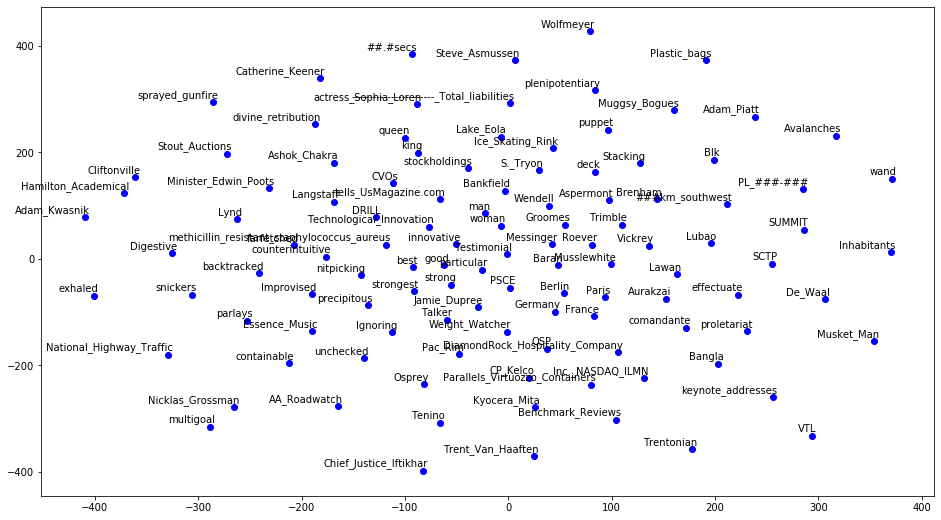

In [0]:
def plot_values(values, labels, figsize = (8,4), c = []):
    x = []
    y = []
    for value in values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=figsize) 
    for i in range(len(labels)):
        plt.scatter(x[i],y[i], color=c[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


import pickle
two_dim_model = pickle.load(open('AIML_DS_WORD2VEC2D_STD.pkl', 'rb'))

wv_labels = {}
for vec, word in two_dim_model:
    wv_labels[word] = vec
    
colors = ['blue' for i in range(len(wv_labels))]

plot_values(wv_labels.values(), list(wv_labels.keys()), figsize = (16, 9), c = colors)

Now, we have given you the 2D representation of different word vectors. Plot the word vectors for the words 'King', 'Queen', 'man', 'women', 'Germany', 'France', 'Berlin', 'Paris', 'best', 'good', 'strong', 'strongest' in green color:

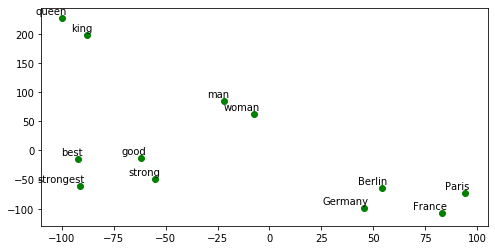

In [0]:
wv_list = ['king', 'queen', 'man', 'woman', 'Germany', 'France', 'Berlin', 'Paris', 'best', 'good', 'strong', 'strongest']
wv_new_labels = {}
for word in wv_list:
    wv_new_labels[word] = wv_labels[word]

colors = ['green' for i in range(len(wv_new_labels))]
plot_values(wv_new_labels.values(), list(wv_new_labels.keys()), c = colors)

Consider the word analogy question: "Queen is to King, as Woman is to what?"

To answer this question, we aim to find what the difference between a "King" and "Queen" is, and apply that difference to a "Woman". If we try to put this mathematically, we can write:- 
$$
 Answer = Woman + King - Queen
$$

Compute the value of the vector on the right hand side of the above equation and plot the resulting vector in red in the same plot as before. 

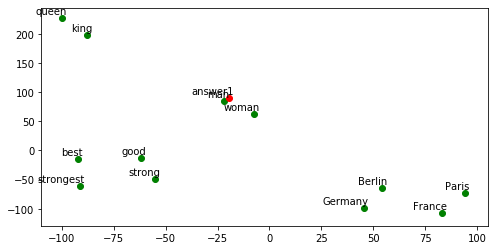

In [0]:
answer = wv_new_labels['woman']  + wv_new_labels['queen'] - wv_new_labels['king']

wv_new_labels['answer1'] = answer

colors = ['green' if word not in ['answer1'] else 'red' for word in wv_new_labels]

plot_values(wv_new_labels.values(), list(wv_new_labels.keys()), c = colors)

In [0]:
wv_new_labels

{'Berlin': array([ 54.274452, -64.469635], dtype=float32),
 'France': array([  83.19701, -107.68167], dtype=float32),
 'Germany': array([ 45.499916, -99.3416  ], dtype=float32),
 'Paris': array([ 94.10659, -72.8086 ], dtype=float32),
 'answer1': array([-19.687668,  90.61377 ], dtype=float32),
 'best': array([-92.34501 , -15.415305], dtype=float32),
 'good': array([-61.84133 , -12.378604], dtype=float32),
 'king': array([-87.6883 , 198.91006], dtype=float32),
 'man': array([-22.006508,  85.321365], dtype=float32),
 'queen': array([-100.098526,  227.57243 ], dtype=float32),
 'strong': array([-55.183422, -49.03513 ], dtype=float32),
 'strongest': array([-91.239624, -60.49361 ], dtype=float32),
 'woman': array([-7.277442, 61.951393], dtype=float32)}

Notice how the answer vector is very close to the vector of the word "Man"? Incidentally, "Man" is the right answer to the word analogy question! This is the power of Word2Vec representations.

### Ungraded Exercise 1

Using this technique answer the following questions.

* Germany is to France, as Paris is to?
* Best is to Good, as Strongest is to?


In [0]:
germany = wv_new_labels['Germany']
france = wv_new_labels['France']
paris = wv_new_labels['Paris']
x = paris + germany - france

In [0]:
wv_new_labels['X'] = x
colors = ['green' if word not in ['X'] else 'red' for word in wv_new_labels]
colors

['green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'red']

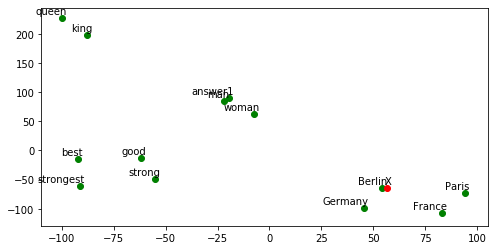

In [0]:
plot_values(wv_new_labels.values(), list(wv_new_labels.keys()), c = colors)

## 1.2 Load pre-trained Word2Vec

Let us now proceed to load the complete pretrained vectors.

In [0]:
model = gensim.models.KeyedVectors.load_word2vec_format('AIML_DS_GOOGLENEWS-VECTORS-NEGATIVE-300_STD.bin', binary=True, limit=500000)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## 1.3 Word2Vec representation

Convert each document into average of the word2vec vectors of all valid words in document

 This method converts documents to word vectors. It first checks if the word is valid according to our initial frequency threshold. Next, if it is, we add the precomputed word vectors together. If the word is valid, but we do not have a valid vector to represent the word, we add a random gaussian noise instead. Since we do not want to induce new noise each time, we store the same noise vector for training and test time in substitute_word_vecs variable.

 

###  Now, let us think about what we mean by "valid vector for representing a word" and why it doesn't exist in some cases?

* It happens when we have  misspelt word in the vocabulary
* If the vocabulary for corpus which you are classifying and the corpus used to find the vector embedding are different.

In [0]:
word2vec_vector_size = 300
def convert_to_w2v(dataset, number_of_documents, substitute_word_vecs={}):
    labels = np.zeros((number_of_documents, 1))
    w2v_rep = np.zeros((number_of_documents, word2vec_vector_size))
    
    # Iterate over the dataset and split into words
    i = 0
    for label, class_name in enumerate(dataset):
        for f in dataset[class_name]:
            text = ' '.join(f).split(' ')
            valid_count = 1
            for word in text:
                
                # Check if word is valid or not according to original dataset pruning
                if word in valid_words:
                    try:
                        w2v_rep[i] += model[word]
                    except:
                        '''The word isn't in our pretrained word-vectors, hence we add a random gaussian noise
                         to account for this. We store the random vector we assigned to the word, and reuse 
                         the same vector during test time to ensure consistency.'''
                        
                        if word not in substitute_word_vecs.keys():
                            substitute_word_vecs[word] = np.random.normal(-0.25, 0.25, word2vec_vector_size)
                            
                        w2v_rep[i] += substitute_word_vecs[word]
                    
                    valid_count += 1
            
            # Average
            w2v_rep[i] = w2v_rep[i] / valid_count
            
            # Save label
            labels[i] = label
            
            i += 1
    
    return w2v_rep, labels, substitute_word_vecs

# Convert the train and test datasets into their word2vec representations
train_w2v_set, train_w2v_labels, substitute_word_vecs = convert_to_w2v(train_set, n_train)
test_w2v_set, test_w2v_labels,_ = convert_to_w2v(test_set, n_test, substitute_word_vecs)

In [0]:
type(substitute_word_vecs)

dict

In [0]:
len(substitute_word_vecs)

6

## 3.1 Document classification using Word2Vec

You may try to understand what distance metric Sklearn's KNeighborsClassifier uses in this case.

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [0]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_w2v_set, train_w2v_labels)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [0]:
predicted_value = neigh.predict(test_w2v_set)

In [0]:
from sklearn.metrics import accuracy_score

In [0]:
accuracy_score(test_w2v_labels,predicted_value)

0.4463157894736842

### Ungraded Exercise 2

The frequency thresholds represents the minimum frequency a word must have to be considered relevant. Experiment with the following values of frequency threshold in your preprocessing step from section 1.2. Re-run all the codes with the new set of valid words and report the accuracies. Use the following values:

`freq_thresh` = 
* 10
* 1000

Report the accuracies using word2vec features.

### Ungraded Exercise 3

In section 1.3, substitute_word_vectors is used as a proxy for a word vector which we do not know. We used a normal gaussian to represent this in that section. Experiment with the type of substitute word vectors used when you do not have a pretrained word vecto is used as the following:

`substitute_word_vecs` : 
* np.ones
* np.zeros

Report the accuracies using only word2vec features.

In [0]:
word2vec_vector_size = 300
def convert_to_w2v(dataset, number_of_documents, substitute_word_vecs={}):
    labels = np.zeros((number_of_documents, 1))
    w2v_rep = np.zeros((number_of_documents, word2vec_vector_size))
    
    # Iterate over the dataset and split into words
    i = 0
    for label, class_name in enumerate(dataset):
        for f in dataset[class_name]:
            text = ' '.join(f).split(' ')
            valid_count = 1
            for word in text:
                
                # Check if word is valid or not according to original dataset pruning
                if word in valid_words:
                    try:
                        w2v_rep[i] += model[word]
                    except:
                        '''The word isn't in our pretrained word-vectors, hence we add a random gaussian noise
                         to account for this. We store the random vector we assigned to the word, and reuse 
                         the same vector during test time to ensure consistency.'''
                        
                        if word not in substitute_word_vecs.keys():
                            substitute_word_vecs[word] = np.ones(word2vec_vector_size)
                            #substitute_word_vecs[word] = np.random.normal(-0.25, 0.25, word2vec_vector_size)
                            
                        w2v_rep[i] += substitute_word_vecs[word]
                    
                    valid_count += 1
            
            # Average
            w2v_rep[i] = w2v_rep[i] / valid_count
            
            # Save label
            labels[i] = label
            
            i += 1
    
    return w2v_rep, labels, substitute_word_vecs

# Convert the train and test datasets into their word2vec representations
train_w2v_set, train_w2v_labels, substitute_word_vecs = convert_to_w2v(train_set, n_train)
test_w2v_set, test_w2v_labels,_ = convert_to_w2v(test_set, n_test, substitute_word_vecs)

In [0]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_w2v_set, train_w2v_labels)
predicted_value = neigh.predict(test_w2v_set)
from sklearn.metrics import accuracy_score
accuracy_score(test_w2v_labels,predicted_value)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.4421052631578947

In [0]:
train_w2v_labels

array([[ 0.],
       [ 0.],
       [ 0.],
       ...,
       [19.],
       [19.],
       [19.]])

### Ungraded Exercise 4

To classify news articles into their 20 news groups, experiment with three different parameter values with the following parameter choices.

* K-NN 
* K : 10, 50
* Distance Metric : Euclidean.


Report the accuracies using  word2vec features.

In [0]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=50, metric='euclidean')
neigh.fit(train_w2v_set, train_w2v_labels)
predicted_value = neigh.predict(test_w2v_set)
from sklearn.metrics import accuracy_score
accuracy_score(test_w2v_labels,predicted_value)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.3663157894736842